In [8]:
"""
Credit for EDA code to this kaggle kernel:
https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
"""
%matplotlib inline
import numpy as np
import pandas as pd 
# import modin.pandas as modpd
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb
import warnings
import gc
import os
warnings.filterwarnings('ignore')

In [13]:
np.random.seed(123)
abs_path = "/media/alaa/Alaa Khaled/Study/Taxi-driver-Arrival-Time-prediction/"
train = pd.read_csv(abs_path + "data/train.csv") 
test = pd.read_csv(abs_path + "data/test.csv")
sample_submission = pd.read_csv(abs_path + "data/sample_submission.csv")

In [3]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [4]:
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


In [5]:
if train.count().min() == train.shape[0] and test.count().min() == test.shape[0]:
    print('We do not need to worry about missing values.')
else:
    print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))
print('The vendor_id has {}/{} distincit train/test values {}.'.format(str(len(set(train.vendor_id))) , str(len(set(test.vendor_id))), str(set(train.vendor_id.unique()) | set(test.vendor_id.unique()))))

We do not need to worry about missing values.
The store_and_fwd_flag has only two values set(['Y', 'N']).
The vendor_id has 2/2 distincit train/test values set([1, 2]).


In [6]:
gc.collect()

11

## Convert datetime features

In [7]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_date'] = train.dropoff_datetime.dt.date

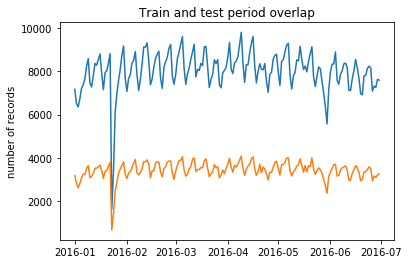

In [8]:
plt.plot(train.groupby('pickup_date').count()[['id']],'-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']],'-', label='test')
plt.title('Train and test period overlap')
plt.ylabel('number of records')
plt.show()

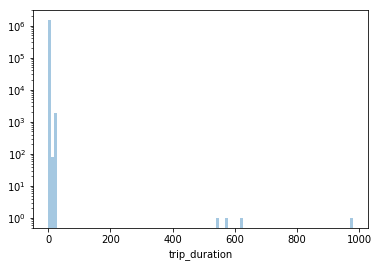

In [9]:
#plot dist of trip_duration(dependent variable)
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(train['trip_duration']/3600,ax=ax,bins=100,kde=False,hist_kws={'log':True})

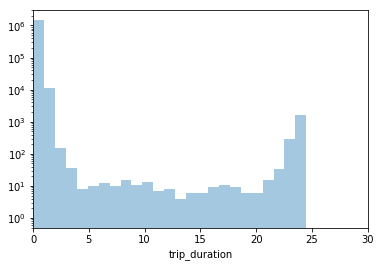

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0, 30) # zoom in trip_duration 0-30
sns.distplot(train['trip_duration']/3600,ax=ax,bins=1000,kde=False,hist_kws={'log':True})

## Feature Extraction

### Datetime features

In [11]:
# diff between weekday and day?
#weekday - Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
#day - Between 1 and the number of days in the given month of the given year.
train['pickup_hour'] = train.pickup_datetime.dt.hour.astype('uint8')
train['pickup_day'] = train.pickup_datetime.dt.day.astype('uint8')
# train['pickup_dayofyear'] = train.pickup_datetime.dt.dayofyear.astype('uint8')
train['pickup_weekday'] = train.pickup_datetime.dt.weekday.astype('uint8')
train['pickup_minute'] = train.pickup_datetime.dt.minute.astype('uint8')
train['pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_weekday_hour'] = train['pickup_weekday']*24 + train['pickup_hour']

test['pickup_hour'] = test.pickup_datetime.dt.hour.astype('uint8')
test['pickup_day'] = test.pickup_datetime.dt.day.astype('uint8')
test['pickup_weekday'] = test.pickup_datetime.dt.weekday.astype('uint8')
test['pickup_minute'] = test.pickup_datetime.dt.minute.astype('uint8')
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_weekday_hour'] = test['pickup_weekday']*24 + test['pickup_hour']

### Location features

In [12]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c # AVG_EARTH_RADIUS=6367
    miles = km *  0.621371
    return miles

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['distance'] = haversine(train.pickup_longitude, train.pickup_latitude,
                              train.dropoff_longitude, train.dropoff_latitude)
test['distance'] = haversine(test.pickup_longitude, test.pickup_latitude,
                              test.dropoff_longitude, test.dropoff_latitude)

In [13]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,dropoff_date,pickup_hour,pickup_day,pickup_weekday,pickup_minute,pickup_hour_weekofyear,pickup_weekday_hour,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,2016-03-14,17,14,0,24,11,17,0.930553
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,2016-06-12,0,12,6,43,23,144,1.121185


In [19]:
train.to_csv("../data/train_mod.csv", index=False)

## Correlation matrix

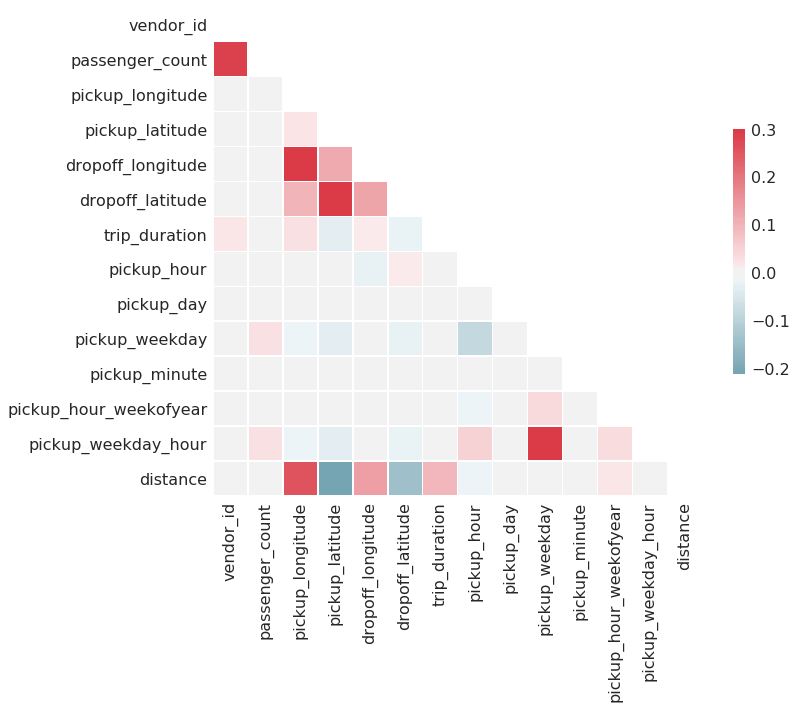

In [14]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

# Use outsource data

In [14]:
wd = pd.read_csv(abs_path + "data/outsource_data/weather_data_nyc_centralpark_2016.csv")

In [15]:
wd['date'] = pd.to_datetime(wd.date, format="%d-%m-%Y")
wd['pickup_day'] = wd['date'].dt.day

In [16]:
wd.head(2)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,pickup_day
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-01-02,40,32,36.0,0.00,0.0,0,2


In [17]:
wd['snow fall'] = wd['snow fall'].replace('T', 0.05).astype(np.float32) 
wd['precipitation'] = wd['precipitation'].replace('T', 0.05).astype(np.float32) 
wd['snow depth'] = wd['snow depth'].replace('T', 0.05).astype(np.float32) 

In [18]:
# A trick to do merging using mongodb
wd.to_csv("../data/outsource_data/weather_data.csv", index=False)

In [19]:
# wd_train = pd.merge(train, wd, on='pickup_day')
# wd_train = wd_train.drop(['date','maximum temperature','minimum temperature'],axis=1)

In [29]:
# sns.set_style('white')
# sns.set_context("paper",font_scale=2)
# corr = wd_train.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(11,9))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
#            square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

#### Do merging using mongodb

In [15]:
fastest1 = pd.read_csv(abs_path + "data/outsource_data/fastest_routes_train_part_1.csv")
fastest2 = pd.read_csv(abs_path + "data/outsource_data/fastest_routes_train_part_2.csv")
fastest = pd.concat([fastest1, fastest2], ignore_index=True)

In [4]:
fastest.head(2)

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."


In [5]:
fastest.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps',
              'starting_street','end_street'], axis=1, inplace=True)

In [6]:
fastest.columns

Index([u'id', u'total_distance', u'total_travel_time'], dtype='object')

In [25]:
fastest.to_csv(abs_path + "data/outsource_data/fastest.csv", index=False)

In [24]:
# wd_train_fastest = pd.merge(wd_train, fastest, on='id', how='outer')
# wd_train_fastest.head(2)

In [26]:
gc.collect()

232

In [27]:
# merge outsource data with test data as well
fastest_test = pd.read_csv(abs_path + 'data/outsource_data/fastest_routes_test.csv')
test = pd.merge(test, fastest_test,on='id',how='outer')
test = test.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
test = pd.merge(test, wd, on='pickup_day')

In [28]:
test.to_csv(abs_path + "data/test_mod.csv", index=False)

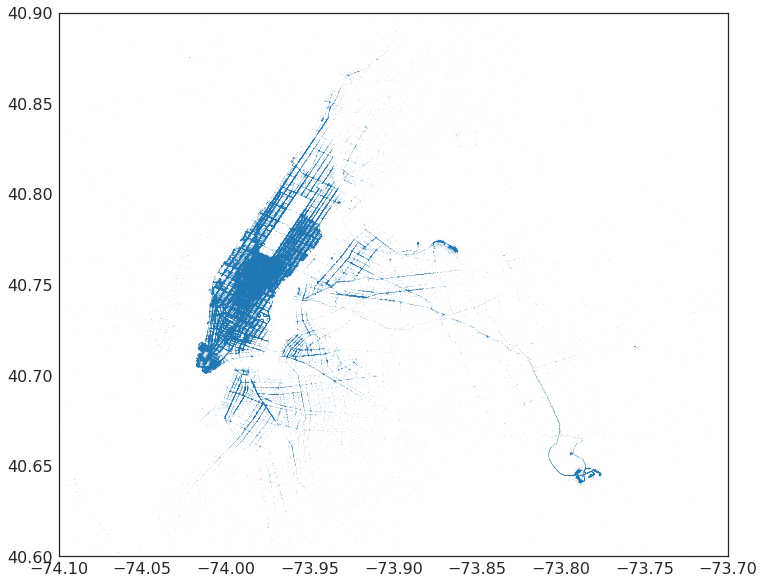

In [26]:
# plot the pickup and dropoff locations
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.01, alpha=1)

# Modeling

In [27]:
def rmslermsle(evaluatorevaluat ,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

In [29]:
for i in train.columns:
    print i

id
vendor_id
pickup_datetime
dropoff_datetime
passenger_count
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
store_and_fwd_flag
trip_duration
pickup_date
dropoff_date
pickup_hour
pickup_day
pickup_weekday
pickup_minute
pickup_hour_weekofyear
pickup_weekday_hour
distance


In [30]:
for i in test.columns:
    print i

id
vendor_id
pickup_datetime
passenger_count
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
store_and_fwd_flag
pickup_date
pickup_hour
pickup_day
pickup_weekday
pickup_minute
pickup_hour_weekofyear
pickup_weekday_hour
distance
total_distance
total_travel_time
date
maximum temperature
minimum temperature
average temperature
precipitation
snow fall
snow depth
